In [1]:
import pandas as pd

In [2]:
import numpy as np

In [5]:
df=pd.read_csv("C:\\Users\\Asus\\Desktop\\Year 4\\DS4002\\Assignments\\Final project\\Student_Depression_Data_Preprocessed.csv")

In [7]:
df['Depression'] = df['Depression'].astype('category')

In [9]:
df = df.astype({col: "category" for col in df.select_dtypes(include="object").columns})

In [11]:
from sklearn.model_selection import train_test_split

# Step 1: Prepare data
X = df.drop('Depression', axis=1)
y = df['Depression']

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(exclude=['object', 'category']).columns

print("Categorical columns:", list(categorical_cols))
print("Numeric columns:", list(numeric_cols))

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Categorical columns: ['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Financial Stress', 'Family History of Mental Illness']
Numeric columns: ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours']
Training set size: 22320
Testing set size: 5581


In [13]:
print(y[:3])

0    1
1    0
2    0
Name: Depression, dtype: category
Categories (2, int64): [0, 1]


In [15]:
df.dtypes

Gender                                   category
Age                                       float64
City                                     category
Profession                               category
Academic Pressure                         float64
Work Pressure                             float64
CGPA                                      float64
Study Satisfaction                        float64
Job Satisfaction                          float64
Sleep Duration                           category
Dietary Habits                           category
Degree                                   category
Have you ever had suicidal thoughts ?    category
Work/Study Hours                          float64
Financial Stress                         category
Family History of Mental Illness         category
Depression                               category
dtype: object

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score,f1_score

In [23]:
accuracy_score(y_pred,y_test)

0.8313922236158394

In [27]:
f1_score(y_pred,y_test)

0.8567950083701111

In [29]:
from sklearn.metrics import accuracy_score, classification_report

In [31]:
print("test set classification report:",classification_report(y_test,y_pred))

test set classification report:               precision    recall  f1-score   support

           0       0.81      0.78      0.80      2343
           1       0.84      0.87      0.86      3238

    accuracy                           0.83      5581
   macro avg       0.83      0.82      0.83      5581
weighted avg       0.83      0.83      0.83      5581



In [33]:
y_train_pred=model.predict(X_train)

In [34]:
print("training set classification report:",classification_report(y_train,y_train_pred))

training set classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      9222
           1       1.00      1.00      1.00     13098

    accuracy                           1.00     22320
   macro avg       1.00      1.00      1.00     22320
weighted avg       1.00      1.00      1.00     22320



0.8567950083701111

In [37]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 2, 4,10],
    'classifier__min_samples_split': [2, 5, 10]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=model,             
    param_grid=param_grid,
    cv=5,                        
    n_jobs=-1,                   
    verbose=2,
    scoring='accuracy'           
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found:")
print(grid_search.best_params_)

print("\nBest cross-validation accuracy:")
print(grid_search.best_score_)

# Predict using best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:
{'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}

Best cross-validation accuracy:
0.8453853046594982


In [38]:
print("Testing Classification Report:")
print(classification_report(y_test, y_pred))

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      2343
           1       0.84      0.87      0.86      3238

    accuracy                           0.83      5581
   macro avg       0.83      0.82      0.83      5581
weighted avg       0.83      0.83      0.83      5581



In [39]:
y_pred_train_tuned=best_model.predict(X_train)

In [40]:
print("\nTraining Classification Report:")
print(classification_report(y_train, y_pred_train_tuned))


Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      9222
           1       0.97      0.99      0.98     13098

    accuracy                           0.97     22320
   macro avg       0.98      0.97      0.97     22320
weighted avg       0.97      0.97      0.97     22320



In [41]:
import matplotlib.pyplot as plt

In [42]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# ----------------------
# Step 1: Encode features using preprocessor
# ----------------------
X_train_encoded = grid_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_encoded = grid_search.best_estimator_.named_steps['preprocessor'].transform(X_test)

# ----------------------
# Step 2: Get feature names
# ----------------------
# Categorical features
categorical_cols = X.select_dtypes(include=['category', 'object']).columns
# Numeric features
numeric_cols = X.select_dtypes(exclude=['category', 'object']).columns

# Encoded categorical names
encoded_cat_names = grid_search.best_estimator_.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .get_feature_names_out()

# All feature names (encoded categorical + numeric)
all_feature_names = np.concatenate([encoded_cat_names, numeric_cols])

# ----------------------
# Step 3: RFECV with RandomForestClassifier
# ----------------------
best_rf = grid_search.best_estimator_.named_steps['classifier']

cv = StratifiedKFold(n_splits=4)
rfecv = RFECV(
    estimator=best_rf,
    step=1,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

rfecv.fit(X_train_encoded, y_train)



Fitting estimator with 115 features.
Fitting estimator with 114 features.
Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting esti

RFECV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(min_samples_split=5, n_estimators=300,
                                       random_state=42),
      n_jobs=-1, scoring='accuracy', verbose=2)

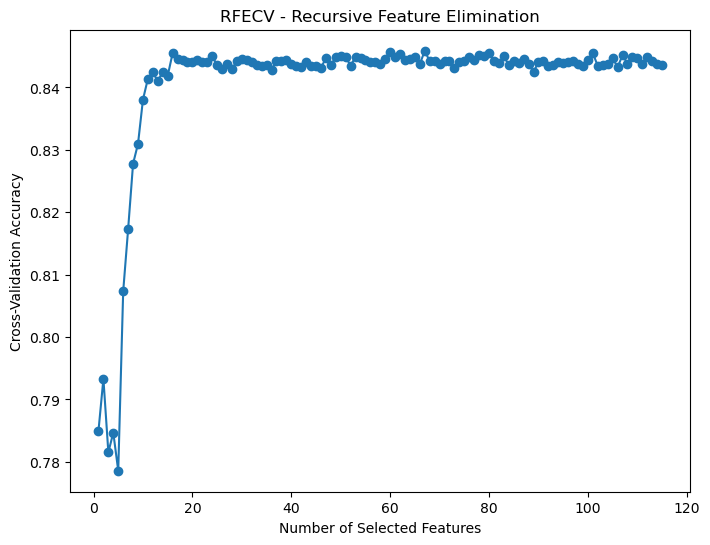

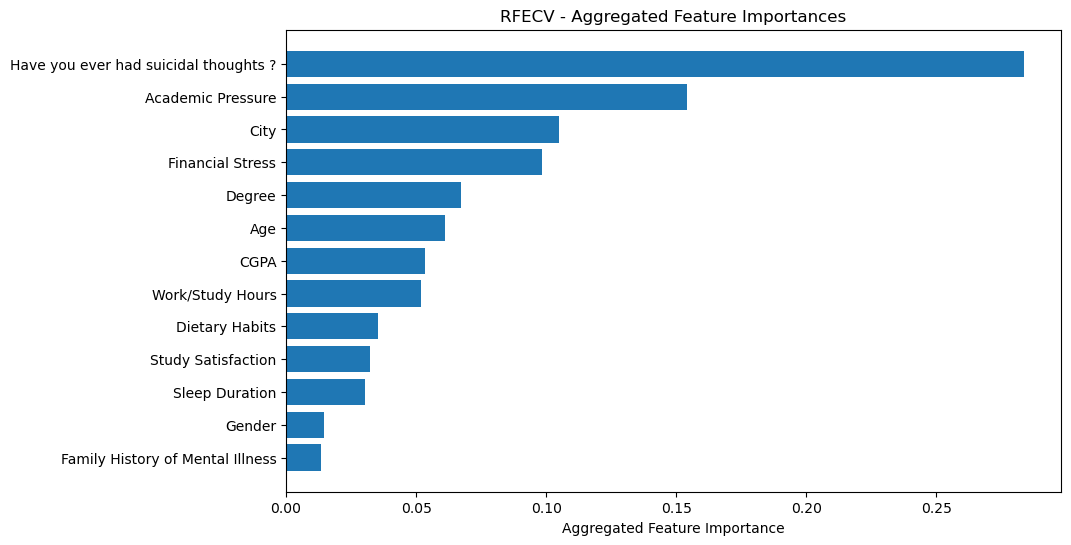

Optimal number of features selected: 67
Selected features (aggregated for categorical variables):
Have you ever had suicidal thoughts ?
Academic Pressure
City
Financial Stress
Degree
Age
CGPA
Work/Study Hours
Dietary Habits
Study Satisfaction
Sleep Duration
Gender
Family History of Mental Illness


In [43]:
# ----------------------
# Step 4: Plot number of features vs CV score
# ----------------------
plt.figure(figsize=(8,6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'], marker='o')
plt.xlabel("Number of Selected Features")
plt.ylabel("Cross-Validation Accuracy")
plt.title("RFECV - Recursive Feature Elimination")
plt.show()

# ----------------------
# Step 5: Aggregate feature importance for original variables
# ----------------------
# Get boolean mask of selected features
selected_mask = rfecv.support_
selected_features = all_feature_names[selected_mask]

# Get feature importances from the fitted RF
importances = rfecv.estimator_.feature_importances_

# Map dummy variables to original categorical variable names
feature_importance_dict = {}

for name, importance in zip(all_feature_names[selected_mask], importances):
    # If dummy variable, take text before '_' as original variable
    if '_' in name and name.split('_')[0] in categorical_cols:
        original_name = name.split('_')[0]
    else:
        original_name = name
    if original_name in feature_importance_dict:
        feature_importance_dict[original_name] += importance
    else:
        feature_importance_dict[original_name] = importance

# Sort features by aggregated importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# ----------------------
# Step 6: Plot aggregated feature importance
# ----------------------
names = [x[0] for x in sorted_features]
values = [x[1] for x in sorted_features]

plt.figure(figsize=(10,6))
plt.barh(range(len(names)), values[::-1], align='center')
plt.yticks(range(len(names)), names[::-1])
plt.xlabel("Aggregated Feature Importance")
plt.title("RFECV - Aggregated Feature Importances")
plt.show()

# ----------------------
# Step 7: Print selected features
# ----------------------
print("Optimal number of features selected:", rfecv.n_features_)
print("Selected features (aggregated for categorical variables):")
for f in names:
    print(f)

In [51]:
# Select features chosen by RFECV
X_train_selected = X_train_encoded[:, selected_mask]
X_test_selected = X_test_encoded[:, selected_mask]
rf_selected_model = rfecv.estimator_  # This is already fitted on selected features
y_train_pred = rf_selected_model.predict(X_train_selected)
y_test_pred = rf_selected_model.predict(X_test_selected)
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")

print("\nTesting Classification Report:")
print(classification_report(y_test, y_test_pred))
print(f"Testing Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

print("\nConfusion Matrix (Test Data):")
print(confusion_matrix(y_test, y_test_pred))


Training Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      9222
           1       0.97      0.98      0.98     13098

    accuracy                           0.97     22320
   macro avg       0.97      0.97      0.97     22320
weighted avg       0.97      0.97      0.97     22320

Training Accuracy: 0.9728

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80      2343
           1       0.85      0.87      0.86      3238

    accuracy                           0.83      5581
   macro avg       0.83      0.82      0.83      5581
weighted avg       0.83      0.83      0.83      5581

Testing Accuracy: 0.8314

Confusion Matrix (Test Data):
[[1829  514]
 [ 427 2811]]


In [53]:
# Selected features from RFECV (all_feature_names[rfecv.support_])
selected_features_mask = rfecv.support_
selected_features = all_feature_names[selected_features_mask]

# Convert back to DataFrame (after one-hot encoding)
X_train_selected = X_train_encoded[:, selected_features_mask]
X_test_selected = X_test_encoded[:, selected_features_mask]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 4,10],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)

# GridSearchCV
grid_search_reduced = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit on reduced features
grid_search_reduced.fit(X_train_selected, y_train)

# Best parameters and score
print("Best parameters for reduced feature set:")
print(grid_search_reduced.best_params_)
print("Best cross-validation accuracy:", grid_search_reduced.best_score_)

# Predict on test set
best_rf_reduced = grid_search_reduced.best_estimator_
y_test_pred_reduced = best_rf_reduced.predict(X_test_selected)
y_train_pred_reduced = best_rf_reduced.predict(X_train_selected)

print("\nTraining Classification Report:")
print(classification_report(y_train, y_train_pred_reduced))

print("Testing Classification Report:")
print(classification_report(y_test, y_test_pred_reduced))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for reduced feature set:
{'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.8472222222222221

Training Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      9222
           1       0.93      0.96      0.95     13098

    accuracy                           0.94     22320
   macro avg       0.94      0.93      0.93     22320
weighted avg       0.94      0.94      0.93     22320

Testing Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      2343
           1       0.84      0.87      0.86      3238

    accuracy                           0.83      5581
   macro avg       0.83      0.82      0.83      5581
weighted avg       0.83      0.83      0.83      5581



In [57]:
import matplotlib.pyplot as plt
import numpy as np
import joblib

importances = best_rf_reduced.feature_importances_

# Map dummy variables to original categorical variable names
feature_importance_dict = {}

for name, importance in zip(selected_features, importances):
    # Group dummy variables by original categorical column
    if '_' in name and name.split('_')[0] in categorical_cols:
        original_name = name.split('_')[0]
    else:
        original_name = name
    feature_importance_dict[original_name] = feature_importance_dict.get(original_name, 0) + importance

# Sort features by aggregated importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
names = [x[0] for x in sorted_features]
values = [x[1] for x in sorted_features]


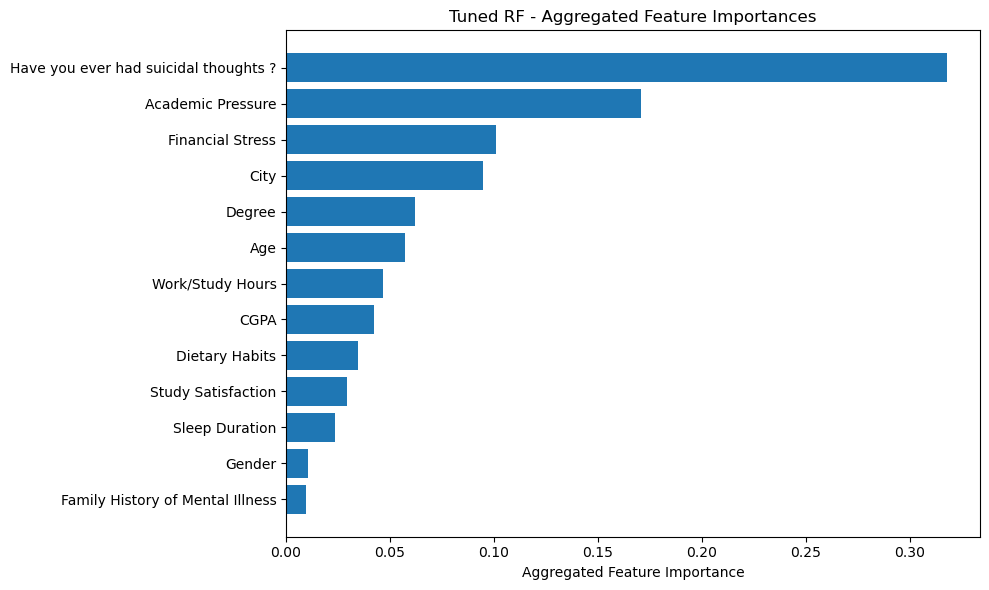

Aggregated feature importance plot saved as 'rf_reduced_feature_importance.png'


In [59]:
plt.figure(figsize=(10,6))
plt.barh(range(len(names)), values[::-1], align='center')
plt.yticks(range(len(names)), names[::-1])
plt.xlabel("Aggregated Feature Importance")
plt.title("Tuned RF - Aggregated Feature Importances")
plt.tight_layout()
plt.savefig("rf_reduced_feature_importance.png", dpi=300)
plt.show()
print("Aggregated feature importance plot saved as 'rf_reduced_feature_importance.png'")


In [61]:
joblib.dump(best_rf_reduced, "tuned_rf_reduced_model.pkl")
print("Tuned RF model on reduced features saved as 'tuned_rf_reduced_model.pkl'")


Tuned RF model on reduced features saved as 'tuned_rf_reduced_model.pkl'


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:53:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Training Set ===
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      9222
           1       0.92      0.94      0.93     13098

    accuracy                           0.92     22320
   macro avg       0.92      0.91      0.91     22320
weighted avg       0.92      0.92      0.92     22320

=== Test Set ===
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      2343
           1       0.85      0.86      0.85      3238

    accuracy                           0.83      5581
   macro avg       0.82      0.82      0.82      5581
weighted avg       0.83      0.83      0.83      5581



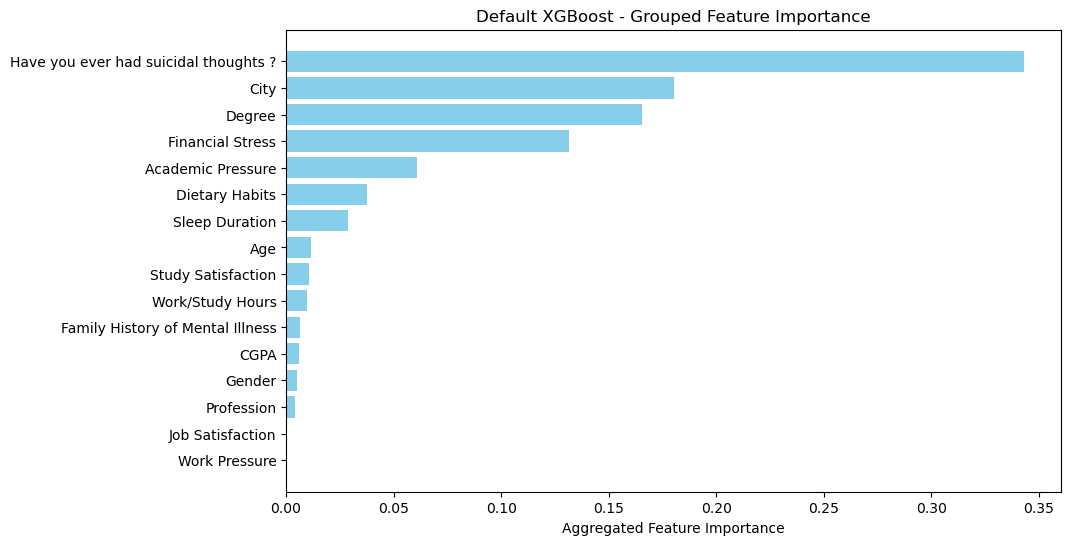

In [93]:
import xgboost as xgb
xgb_default = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Pipeline
pipeline_default = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_default)
])

# Fit
pipeline_default.fit(X_train, y_train)

# Predict
y_train_pred = pipeline_default.predict(X_train)
y_test_pred = pipeline_default.predict(X_test)

# Classification reports
print("=== Training Set ===")
print(classification_report(y_train, y_train_pred))
print("=== Test Set ===")
print(classification_report(y_test, y_test_pred))

# Feature importance
X_train_encoded = pipeline_default.named_steps['preprocessor'].transform(X_train)
encoded_cat_names = pipeline_default.named_steps['preprocessor'] \
    .named_transformers_['cat'].get_feature_names_out()
all_feature_names = np.concatenate([encoded_cat_names, numeric_cols])

importances = pipeline_default.named_steps['classifier'].feature_importances_

# Aggregate importance for categorical variables
feature_importance_dict = {}
for name, importance in zip(all_feature_names, importances):
    if '_' in name and name.split('_')[0] in categorical_cols:
        original_name = name.split('_')[0]
    else:
        original_name = name
    if original_name in feature_importance_dict:
        feature_importance_dict[original_name] += importance
    else:
        feature_importance_dict[original_name] = importance

# Plot grouped feature importance
names = list(feature_importance_dict.keys())
values = list(feature_importance_dict.values())
sorted_idx = np.argsort(values)

plt.figure(figsize=(10,6))
plt.barh(range(len(names)), np.array(values)[sorted_idx], align='center', color='skyblue')
plt.yticks(range(len(names)), np.array(names)[sorted_idx])
plt.xlabel("Aggregated Feature Importance")
plt.title("Default XGBoost - Grouped Feature Importance")
plt.show()


In [95]:

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [97]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

In [99]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 1.0]
}

In [101]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)


In [103]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:54:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         Index(['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits',
       'Degree', 'Have you ever had suicidal thoughts ?', 'Financial Stress',
       'Family History of Mental Illness'],
      dtype='object')),
                                                                        ('num',
                                                                         'passth...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [100, 200, 300],
                         'classifier__subsample': [0.7, 0.8, 1.0]},
             scoring='accuracy', verbose=2)

In [105]:
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
Best CV accuracy: 0.8508960573476703


In [107]:
y_pred_XGB_test = grid_search.best_estimator_.predict(X_test)
y_pred_XGB_train = grid_search.best_estimator_.predict(X_train)

print("Test Accuracy:", accuracy_score(y_test, y_pred_XGB_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_XGB_test))

print("Training Accuracy:", accuracy_score(y_train, y_pred_XGB_train))
print("\nClassification Report:\n", classification_report(y_train, y_pred_XGB_train))

Test Accuracy: 0.8337215552768321

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.80      2343
           1       0.85      0.87      0.86      3238

    accuracy                           0.83      5581
   macro avg       0.83      0.83      0.83      5581
weighted avg       0.83      0.83      0.83      5581

Training Accuracy: 0.8827060931899642

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      9222
           1       0.89      0.92      0.90     13098

    accuracy                           0.88     22320
   macro avg       0.88      0.88      0.88     22320
weighted avg       0.88      0.88      0.88     22320



Fitting estimator with 115 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 114 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 113 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 112 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 111 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 110 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 109 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 108 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 107 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 106 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 105 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 104 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 103 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 102 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 101 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 100 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 99 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 98 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 97 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 96 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 95 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 94 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 93 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 92 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 91 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 90 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 89 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 88 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 87 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 86 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 85 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 84 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 83 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 82 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 81 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting estimator with 80 features.


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:57:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


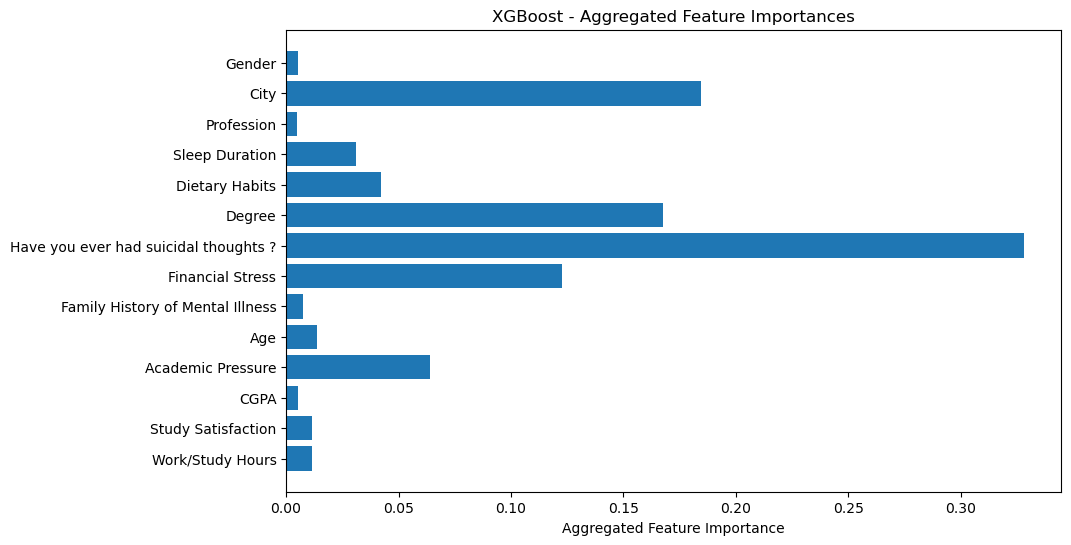

In [109]:
# Transform training set to get encoded feature matrix
X_train_encoded = grid_search.best_estimator_.named_steps['preprocessor'].transform(X_train)

# Get feature names
encoded_cat_names = grid_search.best_estimator_.named_steps['preprocessor'] \
    .named_transformers_['cat'].get_feature_names_out()
all_feature_names = np.concatenate([encoded_cat_names, numeric_cols])

# RFECV for feature selection
cv = StratifiedKFold(n_splits=5)
rfecv = RFECV(
    estimator=grid_search.best_estimator_.named_steps['classifier'],
    step=1,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

rfecv.fit(X_train_encoded, y_train)

# Aggregate feature importance for original variables
selected_mask = rfecv.support_
selected_features = all_feature_names[selected_mask]

importances = rfecv.estimator_.feature_importances_
feature_importance_dict = {}
for name, importance in zip(all_feature_names[selected_mask], importances):
    if '_' in name and name.split('_')[0] in categorical_cols:
        original_name = name.split('_')[0]
    else:
        original_name = name
    if original_name in feature_importance_dict:
        feature_importance_dict[original_name] += importance
    else:
        feature_importance_dict[original_name] = importance

# Plot
names = list(feature_importance_dict.keys())
values = list(feature_importance_dict.values())
plt.figure(figsize=(10,6))
plt.barh(range(len(names)), values[::-1], align='center')
plt.yticks(range(len(names)), names[::-1])
plt.xlabel("Aggregated Feature Importance")
plt.title("XGBoost - Aggregated Feature Importances")
plt.show()


In [117]:
# Get the best estimator from the previous grid search
best_pipeline = grid_search.best_estimator_

# Preprocess training and testing data using the same preprocessor
X_train_encoded = best_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_encoded = best_pipeline.named_steps['preprocessor'].transform(X_test)

# Get feature names from preprocessor
encoded_cat_names = best_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'].get_feature_names_out()
all_feature_names = np.concatenate([encoded_cat_names, numeric_cols])

# Select the features identified by RFECV
X_train_selected = pd.DataFrame(X_train_encoded, columns=all_feature_names)[selected_features]
X_test_selected = pd.DataFrame(X_test_encoded, columns=all_feature_names)[selected_features]

print(f"Selected {X_train_selected.shape[1]} features after RFECV:")
print(selected_features)



Selected 79 features after RFECV:
['Gender_Female' 'City_Agra' 'City_Ahmedabad' 'City_Bangalore'
 'City_Bhopal' 'City_Chennai' 'City_Delhi' 'City_Faridabad'
 'City_Ghaziabad' 'City_Hyderabad' 'City_Indore' 'City_Jaipur'
 'City_Kalyan' 'City_Kanpur' 'City_Kolkata' 'City_Lucknow' 'City_Ludhiana'
 'City_Meerut' 'City_Mumbai' 'City_Nagpur' 'City_Nashik' 'City_Patna'
 'City_Pune' 'City_Rajkot' 'City_Srinagar' 'City_Surat' 'City_Thane'
 'City_Vadodara' 'City_Varanasi' 'City_Vasai-Virar' 'City_Visakhapatnam'
 'Profession_Student' "Sleep Duration_'5-6 hours'"
 "Sleep Duration_'7-8 hours'" "Sleep Duration_'Less than 5 hours'"
 "Sleep Duration_'More than 8 hours'" 'Dietary Habits_Healthy'
 'Dietary Habits_Moderate' 'Dietary Habits_Unhealthy' "Degree_'Class 12'"
 'Degree_B.Arch' 'Degree_B.Com' 'Degree_B.Ed' 'Degree_B.Pharm'
 'Degree_B.Tech' 'Degree_BA' 'Degree_BBA' 'Degree_BCA' 'Degree_BE'
 'Degree_BHM' 'Degree_BSc' 'Degree_LLB' 'Degree_LLM' 'Degree_M.Com'
 'Degree_M.Ed' 'Degree_M.Pharm' 'Degree_

In [119]:
X_train_selected = X_train_encoded[:, rfecv.support_]
X_test_selected = X_test_encoded[:, rfecv.support_]

print(f"Selected {X_train_selected.shape[1]} features after RFECV")

# -----------------------------
# Step 2: Fit XGBoost on reduced features
# -----------------------------
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

xgb_reduced = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_reduced.fit(X_train_selected, y_train)

# -----------------------------
# Step 3: Predictions
# -----------------------------
y_train_pred = xgb_reduced.predict(X_train_selected)
y_test_pred = xgb_reduced.predict(X_test_selected)

# -----------------------------
# Step 4: Classification reports
# -----------------------------
print("=== XGBoost Reduced Model ===")
print("Training Classification Report:\n", classification_report(y_train, y_train_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))

Selected 79 features after RFECV


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:12:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost Reduced Model ===
Training Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      9222
           1       0.92      0.94      0.93     13098

    accuracy                           0.92     22320
   macro avg       0.92      0.91      0.91     22320
weighted avg       0.92      0.92      0.92     22320

Test Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      2343
           1       0.84      0.86      0.85      3238

    accuracy                           0.83      5581
   macro avg       0.82      0.82      0.82      5581
weighted avg       0.83      0.83      0.83      5581



In [121]:
xgb_reduced = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

param_grid_reduced = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0]
}


In [123]:
grid_search_reduced = GridSearchCV(
    estimator=xgb_reduced,
    param_grid=param_grid_reduced,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search_reduced.fit(X_train_selected, y_train)

print("✅ Best parameters (reduced features):", grid_search_reduced.best_params_)
print("✅ Best CV accuracy:", grid_search_reduced.best_score_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\Asus\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best parameters (reduced features): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
✅ Best CV accuracy: 0.8508960573476703


In [125]:
best_xgb_reduced = grid_search_reduced.best_estimator_

y_train_pred_reduced = best_xgb_reduced.predict(X_train_selected)
y_test_pred_reduced = best_xgb_reduced.predict(X_test_selected)

# -------------------------
# Accuracy and Reports
# -------------------------
print("=== Training Set Performance ===")
print("Accuracy:", accuracy_score(y_train, y_train_pred_reduced))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_reduced))

print("\n=== Test Set Performance ===")
print("Accuracy:", accuracy_score(y_test, y_test_pred_reduced))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_reduced))


=== Training Set Performance ===
Accuracy: 0.8827060931899642

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.84      0.85      9222
           1       0.89      0.92      0.90     13098

    accuracy                           0.88     22320
   macro avg       0.88      0.88      0.88     22320
weighted avg       0.88      0.88      0.88     22320


=== Test Set Performance ===
Accuracy: 0.8337215552768321

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.78      0.80      2343
           1       0.85      0.87      0.86      3238

    accuracy                           0.83      5581
   macro avg       0.83      0.83      0.83      5581
weighted avg       0.83      0.83      0.83      5581



In [127]:
# Get feature names for reduced set
reduced_feature_names = np.array(selected_features)

# Initialize dictionary to store aggregated importance
feature_importance_dict = {}

for name, importance in zip(reduced_feature_names, best_xgb_reduced.feature_importances_):
    # If the feature is a dummy from one-hot encoding
    if '_' in name and name.split('_')[0] in categorical_cols:
        original_name = name.split('_')[0]
    else:
        original_name = name
    # Aggregate importance
    if original_name in feature_importance_dict:
        feature_importance_dict[original_name] += importance
    else:
        feature_importance_dict[original_name] = importance


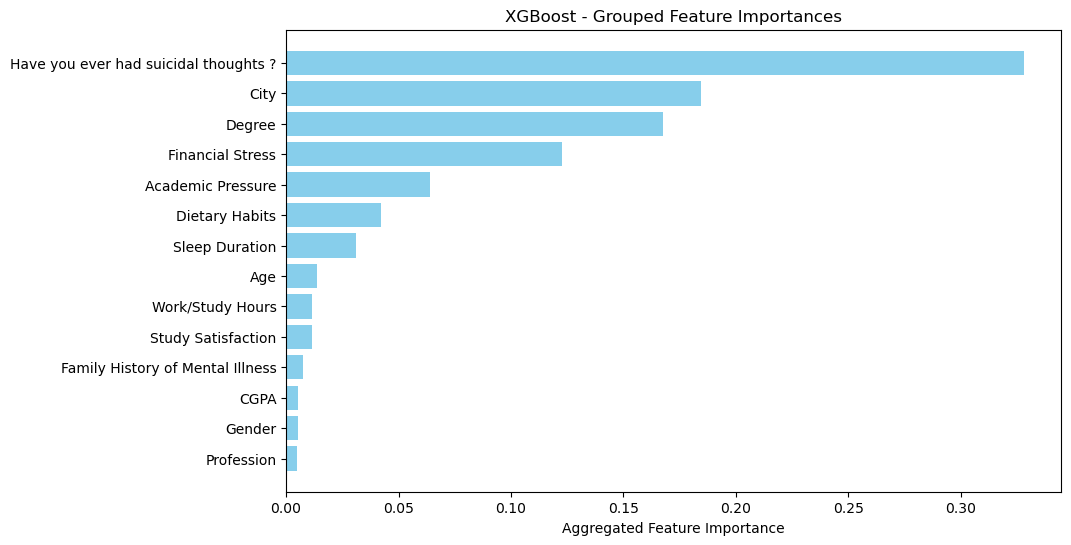

In [129]:
# Sort by importance
sorted_items = sorted(feature_importance_dict.items(), key=lambda x: x[1])
names = [item[0] for item in sorted_items]
values = [item[1] for item in sorted_items]

plt.figure(figsize=(10,6))
plt.barh(range(len(names)), values, align='center', color='skyblue')
plt.yticks(range(len(names)), names)
plt.xlabel("Aggregated Feature Importance")
plt.title("XGBoost - Grouped Feature Importances")
plt.show()
